In [17]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn import o3
from e3nn.io import CartesianTensor
from e3nn.o3 import ReducedTensorProducts
from typing import Dict, Union
from utils.data import train_valid_test_split
from utils.e3nn import Network

import cmcrameri.cm as cm

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# utilities
import time
from tqdm import tqdm
# from utils.utils_data import (load_data, train_valid_test_split, plot_example, plot_predictions, plot_partials,
#                               palette, colors, cmap)
# from utils.utils_model import Network, visualize_layers, train
# from utils.utils_plot import plotly_surface, plot_orbitals, get_middle_feats
from utils.data import (load_data)


import warnings
warnings.filterwarnings("ignore")

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
tqdm.pandas(bar_format=bar_format)
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)
device = "cpu"

In [18]:
# load data
df, species = load_data('data/bec_run.db')
df.head()

,structure,diel,bec,energy,forces,formula,species
0,"(Atom('Nd', [0.21386, 5.14073, 5.74185], magmo...","[[5.63683269, -0.03583374, 0.01910785], [-0.03...","[[[4.18062096, -0.10635331, 0.05667826], [-0.0...",-160.954128,"[[0.04883505, -0.02411291, 0.01005567], [0.016...",H4Nd4Ni4O12,"[O, Nd, Ni, H]"
1,"(Atom('Nd', [0.48857, 5.18121, 5.82727], magmo...","[[5.78986479, -0.0487436, 0.00130012], [-0.048...","[[[3.94453436, 0.05827721, 0.08160375], [0.097...",-160.832210,"[[0.0062039, -0.01181304, -0.00304418], [-0.00...",H4Nd4Ni4O12,"[O, Nd, Ni, H]"
2,"(Atom('Nd', [0.51902, 5.11215, 6.25313], magmo...","[[5.66869607, -0.00180449, 0.01962943], [-0.00...","[[[4.23309052, -0.06272848, -0.0245231], [0.20...",-161.126651,"[[-0.00153404, -0.01371113, 0.03815604], [-0.0...",H4Nd4Ni4O12,"[O, Nd, Ni, H]"
3,"(Atom('Nd', [0.22578, 5.15645, 5.72975], magmo...","[[5.72268242, -0.01338553, -0.00557396], [-0.0...","[[[4.31953816, 0.39699484, 0.10816991], [0.492...",-161.306738,"[[-0.02449503, -0.019128, -0.02941035], [0.001...",H4Nd4Ni4O12,"[O, Nd, Ni, H]"
4,"(Atom('Nd', [0.48497, -0.06402, 5.75643], magm...","[[5.88668571, 0.09451534, -0.001528], [0.09453...","[[[4.12645607, 0.18284011, 0.09932547], [0.383...",-160.415418,"[[0.00508027, -0.03106301, 0.08675875], [-0.10...",H4Nd4Ni4O12,"[O, Nd, Ni, H]"


In [19]:
df.dtypes

structure     object
diel          object
bec           object
energy       float64
forces        object
formula       object
species       object
dtype: object

In [20]:
# Get species
species = ['H', 'O', 'Ni', 'Nd']
species = [Atom(k).number for k in species]
#n_species = list(np.unique(crd.data['species'].sum(), return_counts=True)[1])
Z_max = max([Atom(k).number for k in species])
print(Z_max)

# one-hot encoding atom type and mass
type_encoding = {}
specie_am = []
for Z in tqdm(range(1, Z_max+1), bar_format=bar_format):
    specie = Atom(Z)
    type_encoding[specie.symbol] = Z - 1
    specie_am.append(specie.mass)

type_onehot = torch.eye(len(type_encoding))
am_onehot = torch.diag(torch.tensor(specie_am))

60


100%|██████████| 60/60 [00:00<00:00, 52038.51it/s]                                                                           


In [21]:
species

[1, 8, 28, 60]

In [22]:
type_encoding.keys()

dict_keys(['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd'])

In [23]:
# build data
def build_data(entry, type_encoding, type_onehot, r_max=3.5):

    if device == 'mps':
        symbols = list(entry.structure.symbols).copy()
        positions = torch.from_numpy(entry.structure.positions.copy())
        lattice = torch.from_numpy(entry.structure.cell.array.copy()).unsqueeze(0)
    
        # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
        # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
        edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=entry.structure, cutoff=r_max, self_interaction=True)
        
        # compute the relative distances and unit cell shifts from periodic boundaries
        edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
        edge_vec = (positions[torch.from_numpy(edge_dst)]
                    - positions[torch.from_numpy(edge_src)]
                    + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype).float(), lattice[edge_batch].float()))
    
        # compute edge lengths (rounded only for plotting purposes)
        edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)
        
        data = tg.data.Data(
            pos=positions, lattice=lattice, symbol=symbols,
            x_in=am_onehot[[type_encoding[specie] for specie in symbols]],   # atomic mass (node feature)
            z_in=type_onehot[[type_encoding[specie] for specie in symbols]], # atom type (node attribute)
            edge_index=torch.stack([torch.LongTensor(edge_src).float(), torch.LongTensor(edge_dst).float()], dim=0),
            edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
            edge_vec=edge_vec, edge_len=edge_len,
            y=CartesianTensor("ij=ji").from_cartesian(torch.from_numpy(entry.diel).float(), rtp=ReducedTensorProducts('ij=ji', i='1o')).unsqueeze(0),
        )

    else:
        symbols = list(entry.structure.symbols).copy()
        positions = torch.from_numpy(entry.structure.positions.copy())
        lattice = torch.from_numpy(entry.structure.cell.array.copy()).unsqueeze(0)
    
        # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
        # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
        edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=entry.structure, cutoff=r_max, self_interaction=True)
        
        # compute the relative distances and unit cell shifts from periodic boundaries
        edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
        edge_vec = (positions[torch.from_numpy(edge_dst)]
                    - positions[torch.from_numpy(edge_src)]
                    + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))
    
        # compute edge lengths (rounded only for plotting purposes)
        edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)
        
        data = tg.data.Data(
            pos=positions, lattice=lattice, symbol=symbols,
            x_in=am_onehot[[type_encoding[specie] for specie in symbols]],   # atomic mass (node feature)
            z_in=type_onehot[[type_encoding[specie] for specie in symbols]], # atom type (node attribute)
            edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
            edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
            edge_vec=edge_vec, edge_len=edge_len,
            y=CartesianTensor("ij=ji").from_cartesian(torch.from_numpy(entry.diel), rtp=ReducedTensorProducts('ij=ji', i='1o')).unsqueeze(0),
        )
    
    return data

r_max = 3.5 # cutoff radius
df['data'] = df.progress_apply(lambda x: build_data(x, type_encoding, type_onehot, r_max), axis=1)

100%|██████████| 89/89 [00:18<00:00,  4.79it/s]                                                                              


In [24]:
# entry = df.iloc[0]
# CartesianTensor("ij=ji").from_cartesian(
#         torch.from_numpy(entry.diel), 
#         rtp=ReducedTensorProducts('ij=ji', i='1o')
#     ).unsqueeze(0)

In [25]:
# Train/valid/test split
test_size = 0.1
idx_train, idx_valid, idx_test = train_valid_test_split(df.data, valid_size=test_size, test_size=test_size)

In [26]:
# Format dataloaders
batch_size = 4
dataloader_train = tg.loader.DataLoader(df.iloc[idx_train]['data'].tolist(), batch_size=batch_size, shuffle=True)
dataloader_valid = tg.loader.DataLoader(df.iloc[idx_valid]['data'].tolist(), batch_size=batch_size)
dataloader_test = tg.loader.DataLoader(df.iloc[idx_test]['data'].tolist(), batch_size=batch_size)

In [27]:
# for data in dataloader_train:
#     print(len(data['pos']))
#     batch = data['pos'].new_zeros(data['pos'].shape[0], dtype=torch.long)
# for data in dataloader_train:
#     print(data['batch'])

In [28]:
class E3NN(Network):
    def __init__(self, in_dim, emb_dim, num_layers, max_radius, num_neighbors):
         
        kwargs = {'reduce_output': False,
                  'irreps_in': str(emb_dim)+"x0e",
                  'irreps_out': "1x0e+1x2e",
                  'irreps_node_attr': str(emb_dim)+"x0e",
                  'layers': num_layers,
                  'mul': 32,
                  'lmax': 2,
                  'max_radius': max_radius,
                  'number_of_basis': 10,
                  'radial_layers': 2,
                  'radial_neurons': 64,
                  'num_neighbors': num_neighbors
                 }
        super().__init__(**kwargs)
        
        # definitions
        self.cmap = cm.lipari
        self.in_dim = in_dim
        self.emb_dim = emb_dim
        self.num_layers = num_layers
        self.max_radius = max_radius
        self.num_neighbors = num_neighbors
        self.tij = CartesianTensor("ij=ji")
        self.rtp = ReducedTensorProducts('ij=ji', i='1o')
        
        self.model_name = 'raman_e' + str(emb_dim) + '_l' + str(num_layers)
        
        # embedding
        self.emb_x = nn.Sequential(
            nn.Linear(in_dim, emb_dim),
            nn.ReLU()
        )
        
        self.emb_z = nn.Sequential(
            nn.Linear(in_dim, emb_dim),
            nn.Tanh()
        )

    
    def transform(self, data):
        data['x'] = self.emb_x(data['x_in'])
        data['z'] = self.emb_z(data['z_in'])
        return super().forward(data)[0]
    

    def get_raman(self, y, data, batch):
        y = self.tij.to_cartesian(y, self.rtp)
        ones = torch.ones_like(y[:,0,0])
        dy = torch.stack([torch.autograd.grad(k, data['pos'], ones, create_graph=True)[0] for k in y.flatten(start_dim=1).T])
        dy = dy.permute(1,0,2)

        dy_list = unbatch(dy, batch)
        pos_list = unbatch(data['pos'], batch)
        m_list = unbatch(data['m'], batch)
        
        batch_ids, n_modes = torch.unique(batch, sorted=True, return_counts=True)
        batch2 = torch.repeat_interleave(batch_ids, 3*n_modes**2, dim=0)
        eigen_list = unbatch(data['eigenvec'], batch2)
        
        R = []
        for i in range(len(pos_list)):
            R.append(self.tij.from_cartesian((torch.sum(
                torch.einsum('nij,nmj->nmi', dy_list[i], eigen_list[i].view(len(pos_list[i]),-1,3)/torch.sqrt(m_list[i][...,None])),
                dim=0)*data['vol'][i]/4./np.pi).view(-1,3,3), self.rtp))
        return torch.cat(R)
        
    
    def forward(self, data):
        x = self.transform(data)
        
        # aggregate
        if 'batch' in data:
            batch = data['batch']
        else:
            batch = data['pos'].new_zeros(data['pos'].shape[0], dtype=torch.long)

        y = torch_scatter.scatter_mean(x, batch, dim=0)
        return y
    
    
    def count_parameters(self): 
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    

    def loss_diel(self, y_pred, y_true):
        return nn.MSELoss()(y_pred, y_true)

    
    def loss_raman(self, y_pred, y_true):
        return nn.MSELoss()(y_pred, y_true)
    
    
    def checkpoint(self, dataloader, device):
        self.eval()
        
        loss_cum = 0.
        #with torch.no_grad():
        for j, d in enumerate(dataloader):
            d.to(device)
            d.pos.requires_grad = True
            y_diel_pred = self.forward(d)
            
            loss_diel = self.loss_diel(y_diel_pred, d.y).cpu()
            #loss_raman = self.loss_raman(y_raman_pred, d.raman).cpu()
            loss = loss_diel #+ loss_raman
            
            loss_cum += loss.detach().item()
                
        return loss_cum/len(dataloader)

    
    def fit(self, opt, dataloader_train, dataloader_valid, history, s0, max_iter=10, device="cpu", scheduler=None):
        chkpt = 1

        for step in range(max_iter):
            self.train()

            loss_diel_cum = 0.
            #loss_raman_cum = 0.
            loss_cum = 0.
            start_time = time.time()

            for j, d in enumerate(dataloader_train):
                d.to(device)
                d.pos.requires_grad = True
                #y_diel_pred, y_raman_pred = self.forward(d)
                y_diel_pred = self.forward(d)
                
                loss_diel = self.loss_diel(y_diel_pred, d.y).cpu()
                #loss_raman = self.loss_raman(y_raman_pred, d.raman).cpu()
                loss = loss_diel #+ loss_raman
                
                print(f"Iteration {step+1:5d}    batch {j+1:5d} / {len(dataloader_train):5d}   " +
                      f"batch loss = {loss.data:.4e}, diel. = {loss_diel.data:.4e}", end="\r", flush=True)

                loss_diel_cum += loss_diel.detach().item()
                #loss_raman_cum += loss_raman.detach().item()
                loss_cum += loss.detach().item()
                
                opt.zero_grad()
                loss.backward()
                opt.step()
            
            if scheduler is not None:
                scheduler.step()
            
            end_time = time.time()
            wall = end_time - start_time

            if (step+1)%chkpt == 0:
                print(f"Iteration {step+1:5d}    batch {j+1:5d} / {len(dataloader_train):5d}   " +
                      f"epoch loss = {loss_cum/len(dataloader_train):.4e}, diel. = {loss_diel_cum/len(dataloader_train):.4e}, " )
                      #f"raman = {loss_raman_cum/len(dataloader_train):.4e}")

                loss_valid = self.checkpoint(dataloader_valid, device)
                loss_train = self.checkpoint(dataloader_train, device)

                history.append({
                    'step': step + s0,
                    'wall': wall,
                    'batch': {
                        'loss': loss.item(),
                    },
                    'valid': {
                        'loss': loss_valid,
                    },
                     'train': {
                         'loss': loss_train,
                     },
                })

                yield {
                    'history': history,
                    'state': self.state_dict(),
                    'optimizer': opt.state_dict(),
                    'scheduler': scheduler.state_dict() if scheduler else None
                }

In [29]:
#Z_max = 4
args_enn = {'in_dim': Z_max,
            'emb_dim': 64,
            'num_layers': 2,
            'max_radius': r_max,
            'num_neighbors': 6,
           }

enn = E3NN(**args_enn).to(device)
opt = torch.optim.Adam(enn.parameters(), lr=3e-3)
scheduler = None #torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.99)

model_num = 1
model_path = 'models/' + enn.model_name + '_' + str(model_num) + '.torch'

print(model_path)
#print(enn)
print('Number of parameters:', enn.count_parameters())

models/raman_e64_l2_1.torch
Number of parameters: 4169216


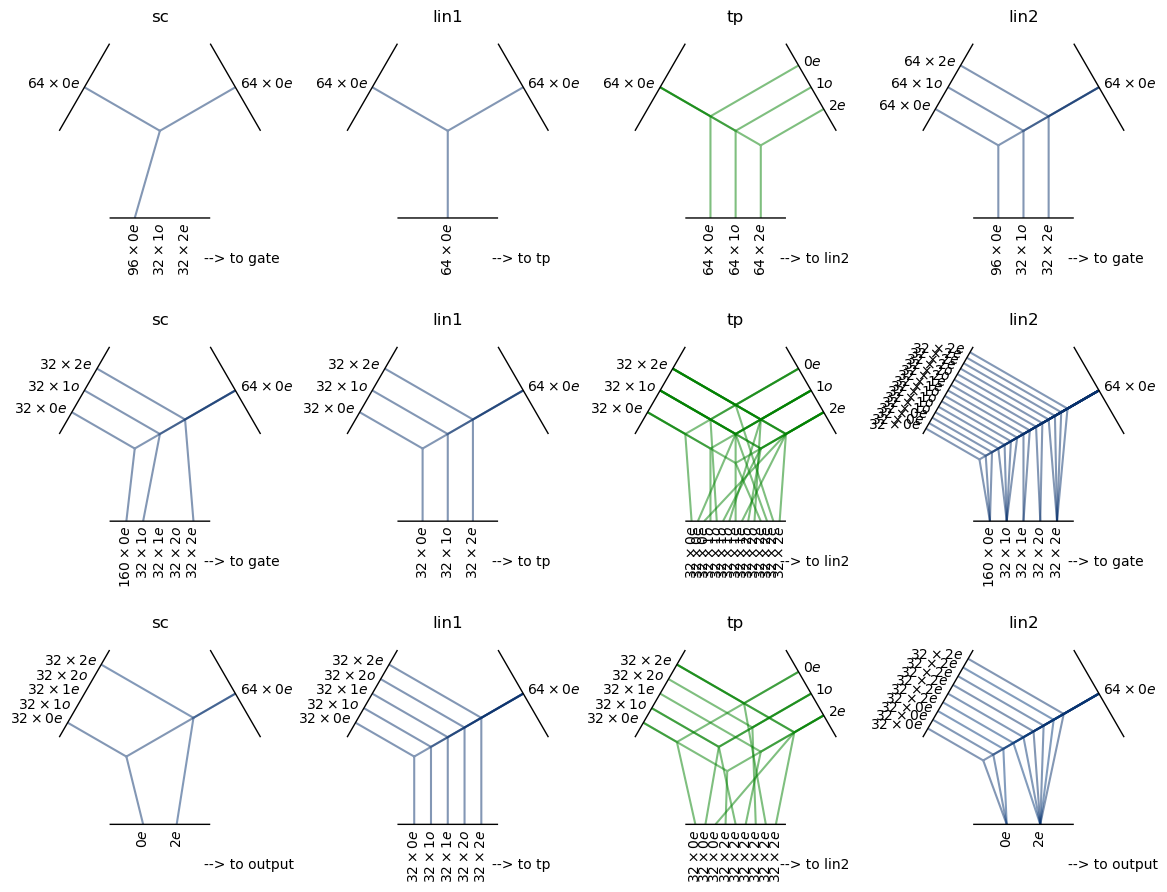

In [30]:
fig = enn.visualize()

In [31]:
resume = False
    
if resume:
    saved = torch.load(model_path, map_location=device)
    enn.load_state_dict(saved['state'])
    opt.load_state_dict(saved['optimizer'])
    try:
        scheduler.load_state_dict(saved['scheduler'])
    except:
        scheduler = None
    history = saved['history']
    s0 = history[-1]['step'] + 1

else:
    history = []
    s0 = 0

In [32]:
# for data in dataloader_train:
#     print(data['x'])

In [33]:
print(Z_max)

60


In [34]:
for data in dataloader_test:
    print(data)

DataBatch(edge_index=[2, 1752], y=[4, 6], pos=[96, 3], lattice=[4, 3, 3], symbol=[4], x_in=[96, 60], z_in=[96, 60], edge_shift=[1752, 3], edge_vec=[1752, 3], edge_len=[4], batch=[96], ptr=[5])
DataBatch(edge_index=[2, 1776], y=[4, 6], pos=[96, 3], lattice=[4, 3, 3], symbol=[4], x_in=[96, 60], z_in=[96, 60], edge_shift=[1776, 3], edge_vec=[1776, 3], edge_len=[4], batch=[96], ptr=[5])
DataBatch(edge_index=[2, 440], y=[1, 6], pos=[24, 3], lattice=[1, 3, 3], symbol=[1], x_in=[24, 60], z_in=[24, 60], edge_shift=[440, 3], edge_vec=[440, 3], edge_len=[1], batch=[24], ptr=[2])


In [125]:
# fit E3NN
for results in enn.fit(opt, dataloader_train, dataloader_valid, history, s0, max_iter=20, device=device,
                       scheduler=scheduler):
    with open(model_path, 'wb') as f:
        torch.save(results, f)

Iteration     1    batch    18 /    18   epoch loss = 1.5703e+01, diel. = 1.5703e+01, 
Iteration     2    batch    18 /    18   epoch loss = 3.0315e+00, diel. = 3.0315e+00, 
Iteration     3    batch    18 /    18   epoch loss = 3.5691e-01, diel. = 3.5691e-01, 
Iteration     4    batch    18 /    18   epoch loss = 1.1482e-01, diel. = 1.1482e-01, 
Iteration     5    batch    18 /    18   epoch loss = 6.6116e-02, diel. = 6.6116e-02, 
Iteration     6    batch    18 /    18   epoch loss = 6.7375e-02, diel. = 6.7375e-02, 
Iteration     7    batch    18 /    18   epoch loss = 5.5935e-02, diel. = 5.5935e-02, 
Iteration     8    batch    18 /    18   epoch loss = 6.4603e-02, diel. = 6.4603e-02, 
Iteration     9    batch    18 /    18   epoch loss = 5.1480e-02, diel. = 5.1480e-02, 
Iteration    10    batch    18 /    18   epoch loss = 5.9964e-02, diel. = 5.9964e-02, 
Iteration    11    batch    18 /    18   epoch loss = 9.1921e-02, diel. = 9.1921e-02, 
Iteration    12    batch    18 /    18   ep

In [128]:
import os 

if not os.path.exists('images/' + enn.model_name + '_' + str(model_num)):
    os.makedirs('images/' + enn.model_name + '_' + str(model_num))

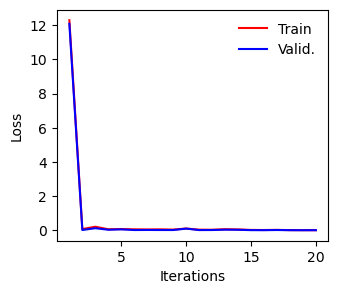

In [130]:
saved = torch.load(model_path, map_location=device)
history = saved['history']

steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

fig, ax = plt.subplots(figsize=(3.5,3))
ax.plot(steps, loss_train, label='Train', color='red')
ax.plot(steps, loss_valid, label='Valid.', color='blue')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
#ax.set_yscale('log')
#fig.savefig('images/' + enn.model_name + '_' + str(model_num) + '/loss.svg', bbox_inches='tight')

In [38]:
entry = df.iloc[idx_test].iloc[6]
entry

structure    (Atom('Nd', [0.05387, 5.1155, 5.78917], magmom...
diel         [[5.55471688, 0.01293767, -0.01049268], [0.012...
bec          [[[4.13103025, -0.17821349, 0.02422252], [0.07...
energy                                             -160.315386
forces       [[0.04276209, -0.04021064, -0.00581475], [-0.0...
formula                                            H4Nd4Ni4O12
species                                         [O, Nd, Ni, H]
data         [(edge_index, [tensor([ 0,  0,  0,  0,  0,  0,...
Name: 40, dtype: object

In [1]:
x = tg.data.Batch.from_data_list([entry.data])
x.pos.requires_grad = True
#
bec_pred = enn(x.to(device))
bec_pred = enn.tij.to_cartesian(bec_pred[0].detach().cpu())[0]

NameError: name 'tg' is not defined

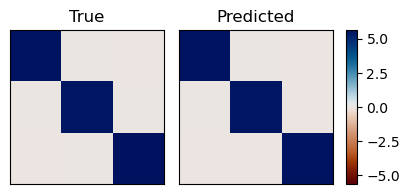

In [153]:
entry = df.iloc[idx_test].iloc[6]

x = tg.data.Batch.from_data_list([entry.data])
x.pos.requires_grad = True
#
bec_pred = enn(x.to(device))
bec_pred = enn.tij.to_cartesian(bec_pred[0].detach().cpu())[0]


fig, ax = plt.subplots(1,3, figsize=(4.5,2), gridspec_kw={'width_ratios': [1,1,0.07]})
plt.subplots_adjust(wspace=0.1)
vmax = np.abs(entry.diel).max()
norm = plt.Normalize(vmin=-vmax, vmax=vmax)

sm = mpl.cm.ScalarMappable(cmap=cm.vik_r, norm=norm)

ax[0].imshow(entry.diel, cmap=sm.cmap, norm=sm.norm)
ax[0].set_title('True')

ax[1].imshow(y, cmap=sm.cmap, norm=sm.norm)
ax[1].set_title('Predicted')

ax[0].set_xticks([]); ax[1].set_xticks([])
ax[0].set_yticks([]); ax[1].set_yticks([])

plt.colorbar(sm, cax=ax[2]);
#fig.savefig('example_dielectric_' + entry.formula.replace(' ','') + '.svg', bbox_inches='tight', transparent=True)

In [154]:
entry.diel

array([[ 5.55471688e+00,  1.29376700e-02, -1.04926800e-02],
       [ 1.29723300e-02,  5.47123027e+00,  3.00695000e-03],
       [-1.05067300e-02,  2.96923000e-03,  5.62476664e+00]])

In [156]:
x = tg.data.Batch.from_data_list([entry.data])
x.pos.requires_grad = True

In [162]:
y = enn(x.to(device))

In [163]:
y

tensor([[ 9.5836e+00, -2.6107e-03,  2.2964e-02, -4.9616e-02, -1.0928e-02,
          6.6856e-03]], grad_fn=<DivBackward0>)

In [164]:
y.detach()

tensor([[ 9.5836e+00, -2.6107e-03,  2.2964e-02, -4.9616e-02, -1.0928e-02,
          6.6856e-03]])

In [159]:
y = enn.tij.to_cartesian(y.detach().cpu(), ReducedTensorProducts('ij=ji', i='1o'))

In [160]:
y

tensor([[[ 5.5486e+00,  1.6238e-02, -1.8461e-03],
         [ 1.6238e-02,  5.4926e+00, -7.7274e-03],
         [-1.8461e-03, -7.7274e-03,  5.5581e+00]]])

In [161]:
y[0]

tensor([[ 5.5486e+00,  1.6238e-02, -1.8461e-03],
        [ 1.6238e-02,  5.4926e+00, -7.7274e-03],
        [-1.8461e-03, -7.7274e-03,  5.5581e+00]])